## Imports

In [1]:
import requests
import pandas as pd
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt

## API Info

In [2]:
USERNAME ='OOIAPI-2VGT2I58H9V44G'
TOKEN= 'HFYV49OQEJ6'

## Time Conversion

In [3]:
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()
pst_delta = 8*3600

def ntp_seconds_to_datetime(ntp_seconds):
    timestamp = datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
    utc_timezone = pytz.timezone('UTC')
    pst_timezone = pytz.timezone('US/Pacific')
    time = utc_timezone.localize(timestamp).astimezone(pst_timezone)
    return time

## Average Calculation

In [4]:
def avgSet(time,velocity,precipitation):
    
    Jan_velocity = []
    Feb_velocity = []
    March_velocity = []
    April_velocity = []
    May_velocity = []
    June_velocity = []
    July_velocity = []
    Aug_velocity = []
    Sept_velocity = []
    Oct_velocity = []
    Nov_velocity = []
    Dec_velocity = []

    Jan_precipitation = []
    Feb_precipitation = []
    March_precipitation = []
    April_precipitation = []
    May_precipitation = []
    June_precipitation = []
    July_precipitation = []
    Aug_precipitation = []
    Sept_precipitation = []
    Oct_precipitation = []
    Nov_precipitation = []
    Dec_precipitation = []

    avg_velocity = []
    avg_precipitation = []

    Months = ['January',
              'February',
              'March',
              'April',
              'May',
              'June',
              'July',
              'August',
              'September',
              'October',
              'November',
              'December']

    for i in range(len(time)):
        if i <= int(round((len(time)/12),0)):
            Jan_velocity.append(velocity[i])
            Jan_precipitation.append(precipitation[i])
        elif i > int(round((len(time)/12),0)) and i <= 2*int(round((len(time)/12),0)):
            Feb_velocity.append(velocity[i])
            Feb_precipitation.append(precipitation[i])
        elif i > 2*int(round((len(time)/12),0)) and i <= 3*int(round((len(time)/12),0)):
            March_velocity.append(velocity[i])
            March_precipitation.append(precipitation[i])
        elif i > 3*int(round((len(time)/12),0)) and i <= 4*int(round((len(time)/12),0)):
            April_velocity.append(velocity[i])
            April_precipitation.append(precipitation[i])
        elif i > 4*int(round((len(time)/12),0)) and i <= 5*int(round((len(time)/12),0)):
            May_velocity.append(velocity[i])
            May_precipitation.append(precipitation[i])
        elif i > 5*int(round((len(time)/12),0)) and i <= 6*int(round((len(time)/12),0)):
            June_velocity.append(velocity[i])
            June_precipitation.append(precipitation[i])
        elif i > 6*int(round((len(time)/12),0)) and i <= 7*int(round((len(time)/12),0)):
            July_velocity.append(velocity[i])
            July_precipitation.append(precipitation[i])
        elif i > 7*int(round((len(time)/12),0)) and i <= 8*int(round((len(time)/12),0)):
            Aug_velocity.append(velocity[i])
            Aug_precipitation.append(precipitation[i])
        elif i > 8*int(round((len(time)/12),0)) and i <= 9*int(round((len(time)/12),0)):
            Sept_velocity.append(velocity[i])
            Sept_precipitation.append(precipitation[i])
        elif i > 9*int(round((len(time)/12),0)) and i <= 10*int(round((len(time)/12),0)):
            Oct_velocity.append(velocity[i])
            Oct_precipitation.append(precipitation[i])
        elif i > 10*int(round((len(time)/12),0)) and i <= 11*int(round((len(time)/12),0)):
            Nov_velocity.append(velocity[i])
            Nov_precipitation.append(precipitation[i])
        elif i > 11*int(round((len(time)/12),0)):
            Dec_velocity.append(velocity[i])
            Dec_precipitation.append(precipitation[i])

    avg_velocity.append(np.mean(Dec_velocity))
    avg_precipitation.append(np.mean(Dec_precipitation))
    avg_velocity.append(np.mean(Nov_velocity))
    avg_precipitation.append(np.mean(Nov_precipitation))
    avg_velocity.append(np.mean(Oct_velocity))
    avg_precipitation.append(np.mean(Oct_precipitation))
    avg_velocity.append(np.mean(Sept_velocity))
    avg_precipitation.append(np.mean(Sept_precipitation))
    avg_velocity.append(np.mean(Aug_velocity))
    avg_precipitation.append(np.mean(Aug_precipitation))
    avg_velocity.append(np.mean(July_velocity))
    avg_precipitation.append(np.mean(July_precipitation))
    avg_velocity.append(np.mean(June_velocity))
    avg_precipitation.append(np.mean(June_precipitation))
    avg_velocity.append(np.mean(May_velocity))
    avg_precipitation.append(np.mean(May_precipitation))
    avg_velocity.append(np.mean(April_velocity))
    avg_precipitation.append(np.mean(April_precipitation))
    avg_velocity.append(np.mean(March_velocity))
    avg_precipitation.append(np.mean(March_precipitation))
    avg_velocity.append(np.mean(Feb_velocity))
    avg_precipitation.append(np.mean(Feb_precipitation))
    avg_velocity.append(np.mean(Jan_velocity))
    avg_precipitation.append(np.mean(Jan_precipitation))

    return avg_velocity,avg_precipitation,Months

## Sources

In [5]:
data_request_url = ['https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE02SHSM/SBD11/06-METBKA000/telemetered/metbk_a_dcl_instrument?beginDT=2019-01-01T00:31:20.712Z&endDT=2019-12-31T00:31:20.712Z&limit=1000',
                   'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSSM/SBD11/06-METBKA000/telemetered/metbk_a_dcl_instrument?beginDT=2019-01-01T04:33:58.629Z&endDT=2019-12-31T04:33:58.629Z&limit=1000']

## Saved Values for Cross-Correlation

In [6]:
OSSM_time = []
OSSM_velocity = []
OSSM_precipitation = []

OOSM_time = []
OOSM_velocity = []
OOSM_precipitation = []

## Plots for Rain and Wind

Red is for no Rain or Wind
Blue is for Wind and no Rain
Green is for Rain and no Wind
Yellow is for both Rain and Wind


C:\Users\neilt\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


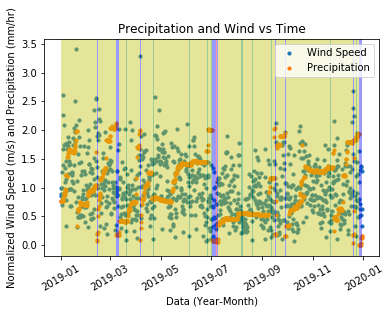

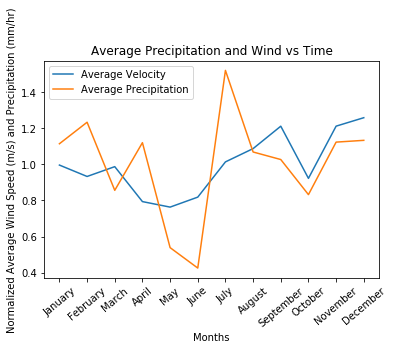

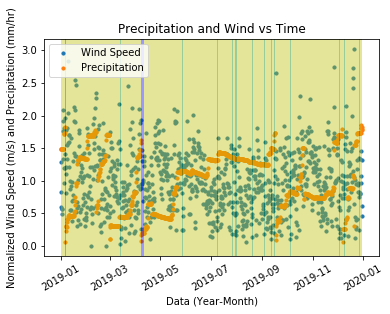

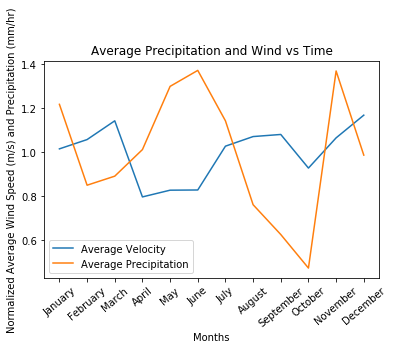

In [7]:
print('Red is for no Rain or Wind')
print('Blue is for Wind and no Rain')
print('Green is for Rain and no Wind')
print('Yellow is for both Rain and Wind')
for i in range(len(data_request_url)):
    r = requests.get(data_request_url[i], auth=(USERNAME, TOKEN))
    data = r.json()
    time = []
    velocity = []
    precipitation = []
    
    for j in range(len(data)):
        time.append(ntp_seconds_to_datetime(data[j]['time']))
        wind_direction = np.sqrt((np.square(data[j]['northward_wind_velocity']))+(np.square(data[j]['eastward_wind_velocity'])))
        velocity.append(wind_direction)
        precipitation.append(data[j]['precipitation'])
        if i == 0:
            OSSM_time.append(ntp_seconds_to_datetime(data[j]['time']))
            OSSM_velocity.append(wind_direction)
            OSSM_precipitation.append(data[j]['precipitation'])
        elif i == 1:
            OOSM_time.append(ntp_seconds_to_datetime(data[j]['time']))
            OOSM_velocity.append(wind_direction)
            OOSM_precipitation.append(data[j]['precipitation'])
    
    from numpy import *
    velocity = np.asarray(velocity)
    where_are_NaNs = isnan(velocity)
    velocity[where_are_NaNs] = 0

    for i in range(len(time)-1):
        if velocity[i]/np.mean(velocity) < .25 and precipitation[i]/np.mean(precipitation) < .25:
            #Case 1: No rain or wind
            plt.axvspan(time[i], time[i+1], facecolor='r', alpha=.4)
        elif velocity[i]/np.mean(velocity) >= .25 and precipitation[i]/np.mean(precipitation) < .25:
            #Case 2: Wind and no rain
            plt.axvspan(time[i], time[i+1], facecolor='b', alpha=.4)
        elif velocity[i]/np.mean(velocity) < .25 and precipitation[i]/np.mean(precipitation) >= .25:
            #Case 3: Rain and no wind
            plt.axvspan(time[i], time[i+1], facecolor='g', alpha=.4)
        else:
            #Case 4: Rain and Wind
            plt.axvspan(time[i], time[i+1], facecolor='y', alpha=.4)
    
    plt.scatter(time,velocity/np.mean(velocity),label = 'Wind Speed',s=10)
    plt.scatter(time,precipitation/np.mean(precipitation),label = 'Precipitation',s=10)
    plt.legend()
    plt.xticks(rotation=30)
    plt.xlabel('Data (Year-Month)')
    plt.ylabel('Normalized Wind Speed (m/s) and Precipitation (mm/hr)')
    plt.title('Precipitation and Wind vs Time')
    plt.show()
    
    results = avgSet(time,velocity,precipitation)
    #0 = velocity
    #1 = precipitation
    #2 = months
    
    plt.plot(results[2],results[0]/np.mean(velocity),label = 'Average Velocity')
    plt.plot(results[2],results[1]/np.mean(precipitation),label = 'Average Precipitation')
    plt.legend()
    plt.xticks(rotation=40)
    plt.xlabel('Months')
    plt.ylabel('Normalized Average Wind Speed (m/s) and Precipitation (mm/hr)')
    plt.title('Average Precipitation and Wind vs Time')
    plt.show()

## Cross-Correlation for Wind

max correlation is at lag 0
Lag in Days: 0
max correlation is 0.6314010061301172
The x-axis with 2001 points corresponds to all of the index values in the cross-correlation set


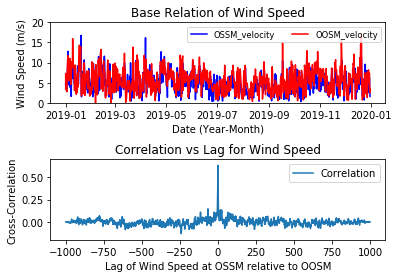

In [8]:
OSSM_velocity = np.asarray(OSSM_velocity)
where_are_NaNs = isnan(OSSM_velocity)
OSSM_velocity[where_are_NaNs] = 0
OOSM_velocity = np.asarray(OOSM_velocity)
where_are_NaNs = isnan(OOSM_velocity)
OOSM_velocity[where_are_NaNs] = 0

y1 = OSSM_velocity
y2 = OOSM_velocity

x = OSSM_time

lags = np.arange(-len(y1) + 1, len(y1))
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (len(y1) * y1.std() * y2.std())

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='OSSM_velocity')
ax.plot(x, y2, 'r', label='OOSM_velocity')
ax.set_ylim(0, 20)
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('Base Relation of Wind Speed')
ax.set_ylabel('Wind Speed (m/s)')
ax.set_xlabel('Date (Year-Month)')


ax = axs[1]
ax.plot(lags, ccor, label='Correlation')
ax.legend()
ax.set_ylim(-.2, .7)
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag of Wind Speed at OSSM relative to OOSM')
ax.set_title('Correlation vs Lag for Wind Speed')

plt.subplots_adjust(hspace=.7)

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)
days = (maxlag/len(time))*365
print('Lag in Days: %d' % days)
maxccor = np.max(ccor)
print('max correlation is ' + str(maxccor))
z=len(lags)
print('The x-axis with %d points corresponds to all of the index values in the cross-correlation set'  % z)

## Cross-Correlation for Rain

max correlation is at lag 341
Lag in Days: 124
max correlation is 0.3515930061267975
The x-axis with 2001 points corresponds to all of the index values in the cross-correlation set


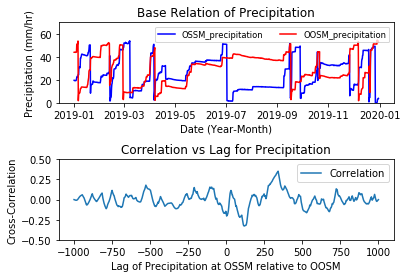

In [9]:
y1 = np.asarray(OSSM_precipitation)
y2 = np.asarray(OOSM_precipitation)

x = OSSM_time

lags = np.arange(-len(y1) + 1, len(y1))
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (len(y1) * y1.std() * y2.std())

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='OSSM_precipitation')
ax.plot(x, y2, 'r', label='OOSM_precipitation')
ax.set_ylim(0, 70)
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('Base Relation of Precipitation')
ax.set_ylabel('Precipitation (mm/hr)')
ax.set_xlabel('Date (Year-Month)')

ax = axs[1]
ax.plot(lags, ccor, label='Correlation')
ax.legend()
ax.set_ylim(-.5, .5)
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag of Precipitation at OSSM relative to OOSM')
ax.set_title('Correlation vs Lag for Precipitation')

plt.subplots_adjust(hspace=.7)

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)
days = (maxlag/len(time))*365
print('Lag in Days: %d' % days)
maxccor = np.max(ccor)
print('max correlation is ' + str(maxccor))
z=len(lags)
print('The x-axis with %d points corresponds to all of the index values in the cross-correlation set' % z)